c:\Users\tadas\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


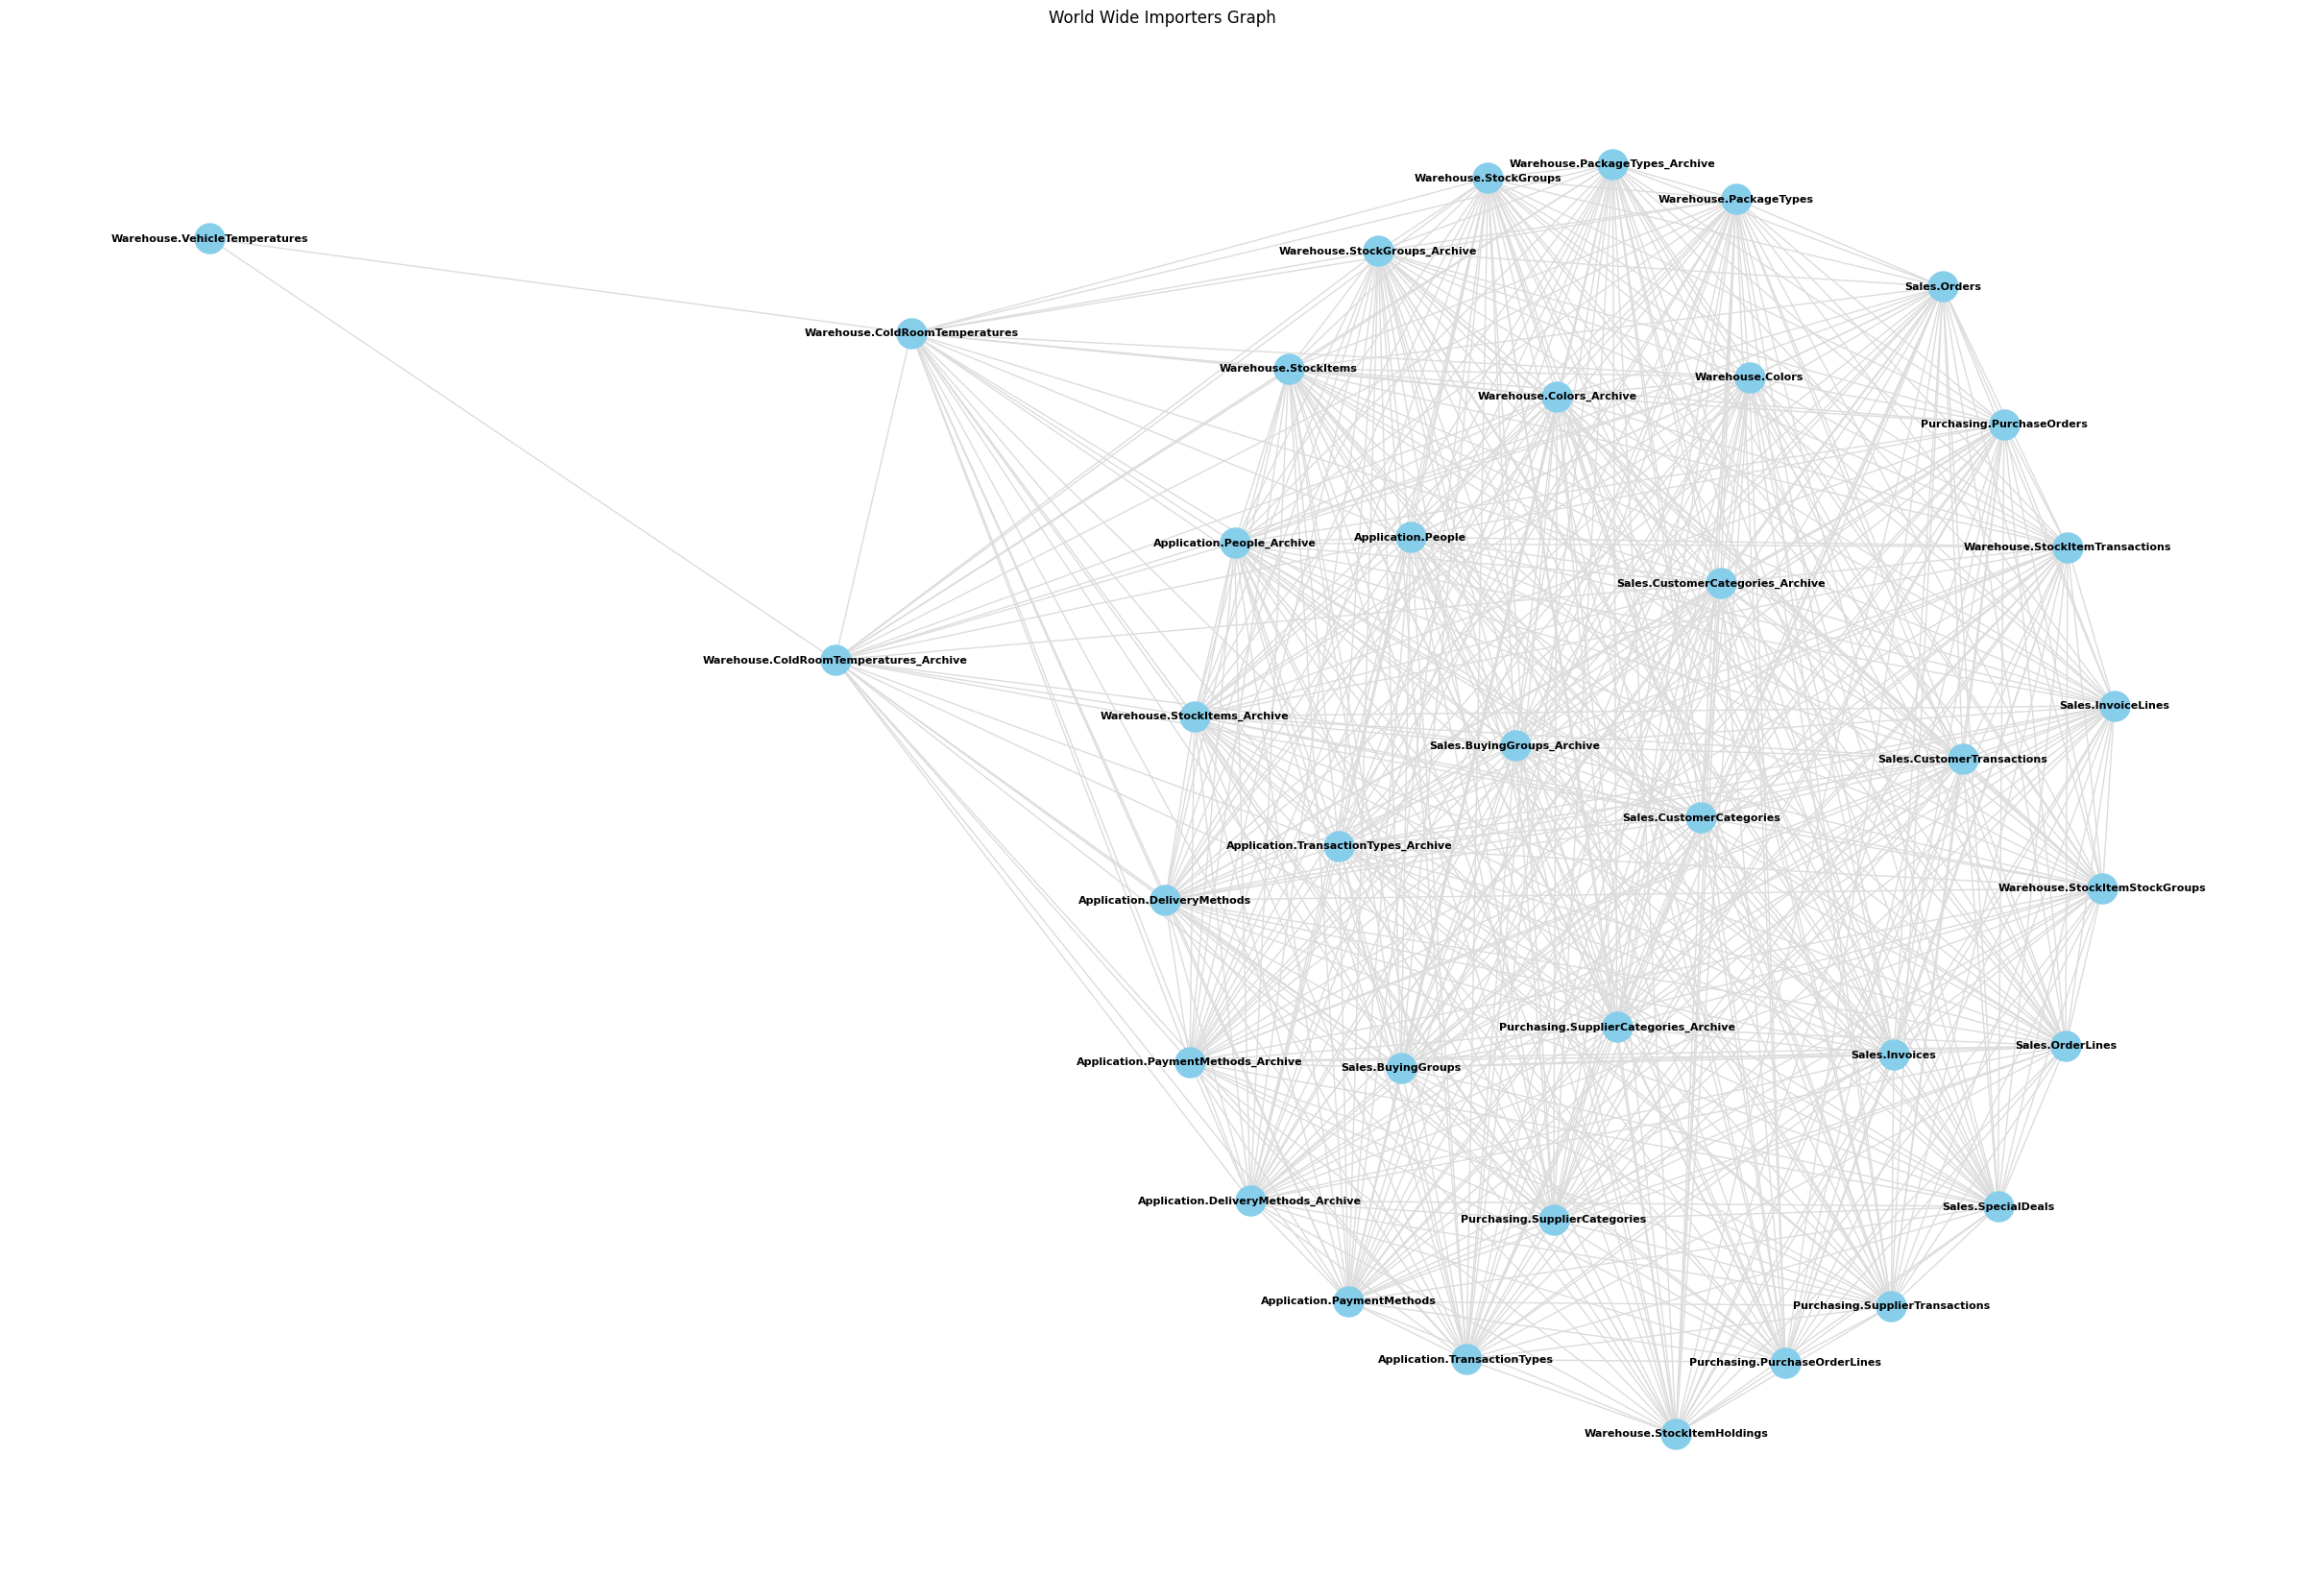

In [1]:
import networkx as nx
import pickle
import matplotlib.pyplot as plt
from node2vec import Node2Vec
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier

# Load the graph
with open(r'C:\\Python\\Python\\AAA_UNI\\MBD\\Project\\gitlab\\graph_analysis\\wwi_graph_degree_org.pickle', 'rb') as f:
    G = pickle.load(f)

# Define the layout positions
pos = nx.kamada_kawai_layout(G)

# Identify isolated nodes
isolated_nodes = list(nx.isolates(G))

# Plot the graph
plt.figure(figsize=(24, 16))
nx.draw(G, pos, edge_color="gainsboro", with_labels=True, node_size=500, node_color='skyblue', font_size=8, font_weight='bold')
nx.draw_networkx_nodes(G, pos, nodelist=isolated_nodes, node_color='red', node_size=500)
plt.title("World Wide Importers Graph")
plt.show()

In [2]:
# Define the random walk clustering function
def random_walk_clustering(G, num_clusters: int = 5, 
                           dimensions: int = 64, 
                           walk_length: int = 3, 
                           num_walks: int = 1000, 
                           workers: int = 10):
    # Generate walks
    node2vec = Node2Vec(G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    
    # Create embeddings
    embeddings = [model.wv[str(node)] for node in G.nodes()]
    
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)

    # Train a Gradient Boosting Classifier on the embeddings
    gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=10, random_state=42)
    gbc.fit(embeddings, cluster_labels)
    
    # Predict the cluster labels using the trained Gradient Boosting Classifier
    cluster_labels = gbc.predict(embeddings)
    
    return cluster_labels

In [3]:
# Apply random walk clustering
num_clusters = 6
cluster_labels = random_walk_clustering(G, num_clusters=num_clusters)

Computing transition probabilities: 100%|██████████| 37/37 [00:00<00:00, 146.72it/s]
c:\Users\tadas\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\tadas\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [4]:
# Define the visualization function
def visualize_clusters(G, cluster_labels, title, ax):
    pos = nx.kamada_kawai_layout(G)
    num_clusters = len(set(cluster_labels))
    cmap = plt.cm.get_cmap('viridis', num_clusters)
    node_colors = [cmap(label) for label in cluster_labels]
    
    nx.draw(G, pos=pos, with_labels=True, node_color=node_colors, cmap=plt.cm.viridis, node_size=500, font_size=8, font_weight='bold', ax=ax)
    ax.set_title(title)

C:\Users\tadas\AppData\Local\Temp\ipykernel_6448\4173744929.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', num_clusters)
c:\Users\tadas\AppData\Local\Programs\Python\Python310\lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


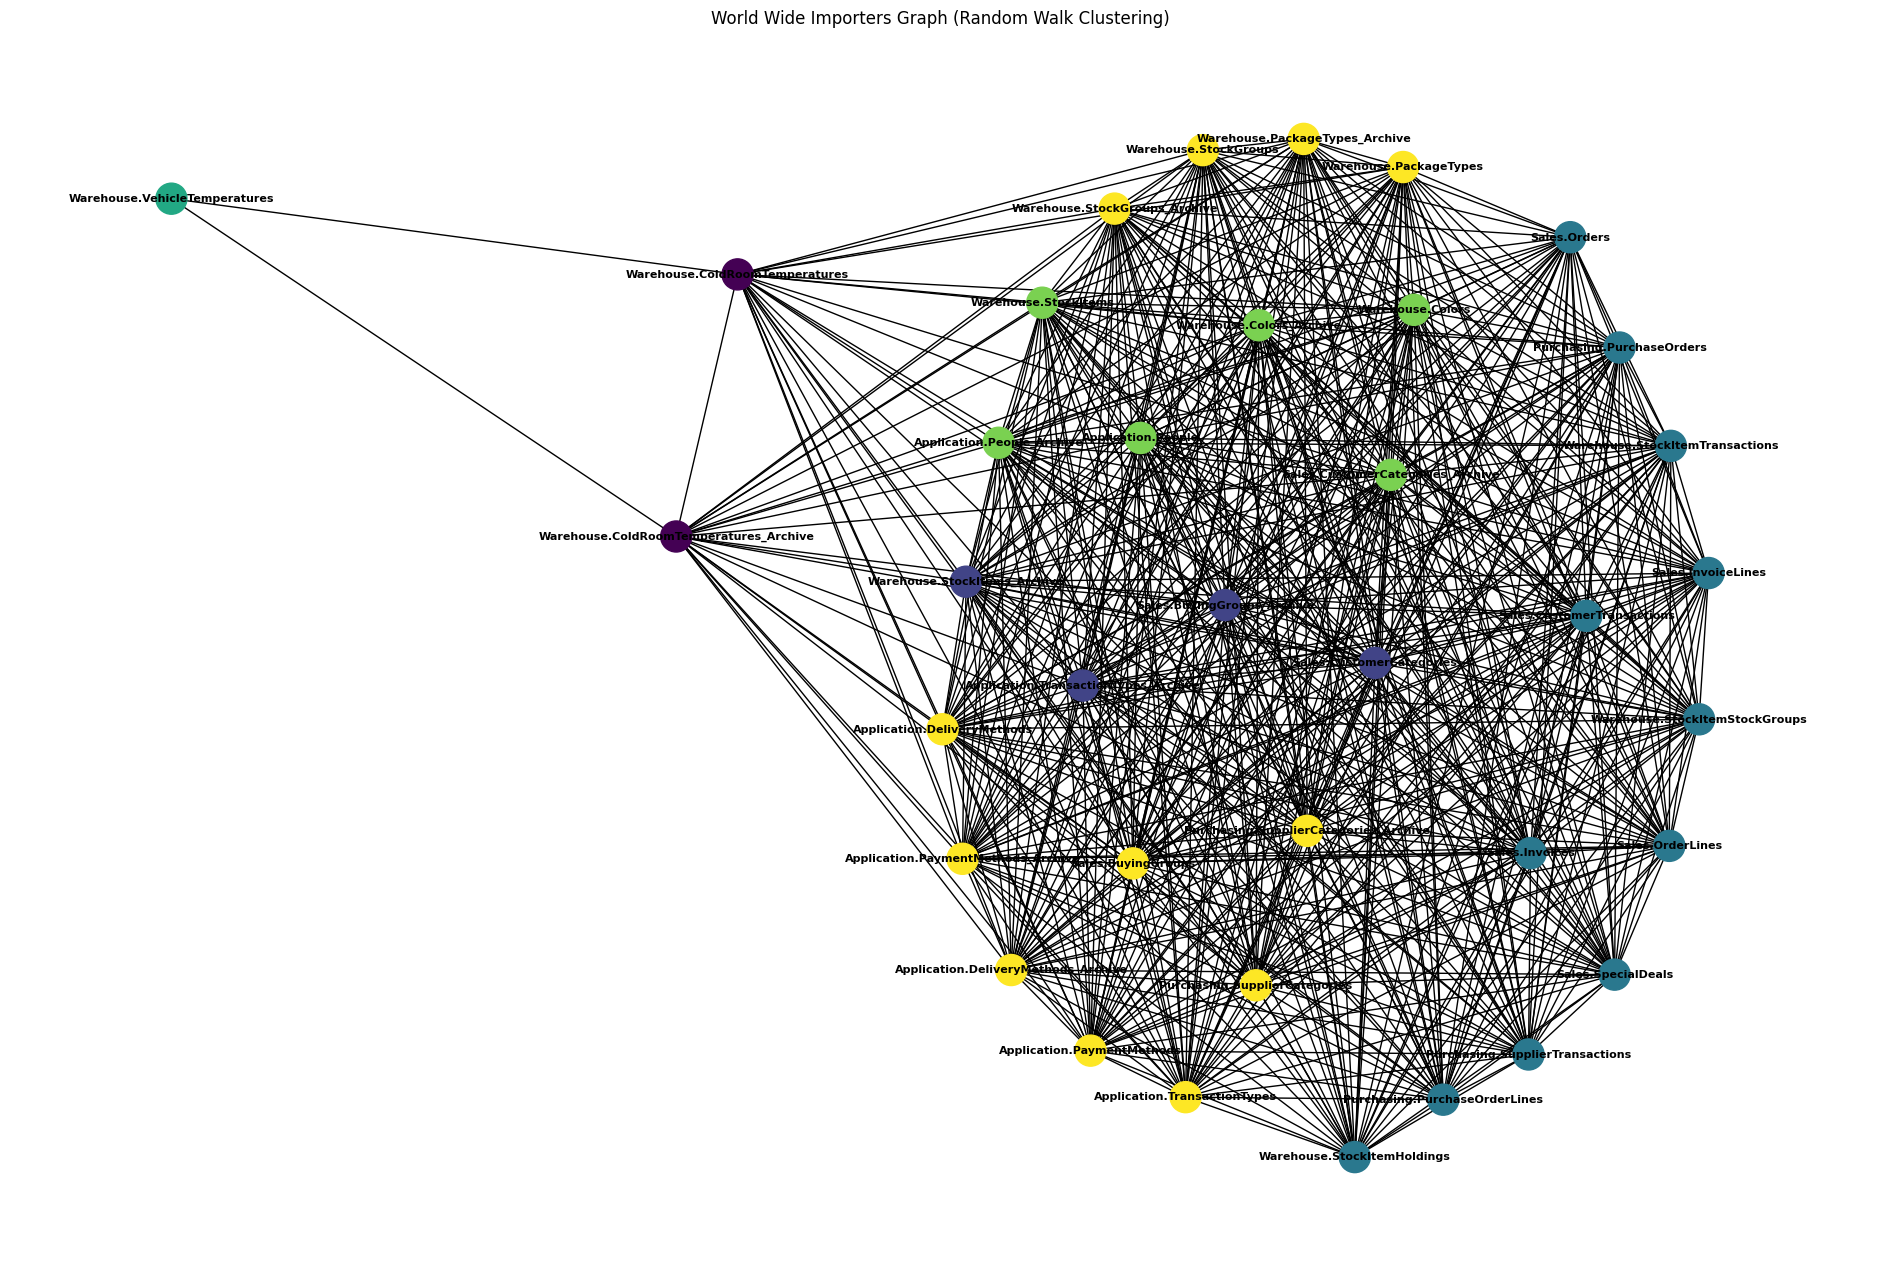

In [5]:
# Plot the clustered graph
fig, ax = plt.subplots(figsize=(24, 16))
visualize_clusters(G, cluster_labels, "World Wide Importers Graph (Random Walk Clustering)", ax)
plt.show()

In [6]:
# Create dataframes for the clusters
def create_cluster_dataframe(G, cluster_labels):
    data = [{'cluster_label': cluster, 'node_label': node.split('.')[1] if '.' in node else node} for node, cluster in zip(G.nodes(), cluster_labels)]
    df = pd.DataFrame(data)
    return df

df_clusters = create_cluster_dataframe(G, cluster_labels)

In [7]:
# Load the table names DataFrame
table_names_df = pd.read_csv(r"C:\\Python\\Python\\AAA_UNI\\MBD\\Project\\gitlab\\graph_analysis\\tables_and_schemas_wwi.csv")

In [8]:
# Define the similarity calculation function
def calculate_similarity(schema_df, cluster_df):
    schema_set = set(schema_df['table_name'])
    matching = sum(1 for label in cluster_df['node_label'] if label in schema_set)
    total_schema = len(schema_df)
    total_cluster = len(cluster_df)
    return matching, total_schema, total_cluster

In [9]:
# Define the function to calculate best matches
def calculate_best_matches(subgraph_node_data):
    best_matches = {}
    best_similarity = {}
    match_ratio = {}

    unique_clusters = subgraph_node_data['cluster_label'].unique()
    for cluster in unique_clusters:
        cluster_df = subgraph_node_data[subgraph_node_data['cluster_label'] == cluster]
        best_similarity[cluster] = 0.0
        best_matches[cluster] = None

        unique_schemas = table_names_df['table_schema'].unique()

        for schema in unique_schemas:
            schema_df = table_names_df[table_names_df['table_schema'] == schema]

            matching, total_schema, total_cluster = calculate_similarity(schema_df, cluster_df)

            similarity_percentage = (matching / total_cluster) * 100

            if similarity_percentage > best_similarity[cluster]:
                best_similarity[cluster] = similarity_percentage
                best_matches[cluster] = schema

            match_ratio[(cluster, schema)] = f"{total_cluster}/{matching}"

    overall_average_similarity = 0
    for cluster, schema in best_matches.items():
        if schema is not None:
            print(f"Best match for cluster {cluster+1} is schema '{schema}' with similarity {best_similarity[cluster]:.2f}% ({match_ratio[(cluster, schema)]})")
            overall_average_similarity += best_similarity[cluster]
    print(f'Overall Average similarity: {(overall_average_similarity/len(best_matches.items())):.2f}%')

In [10]:
# Apply the similarity calculation to the clustered graph
print("World Wide Importers Graph Clustering:")
calculate_best_matches(df_clusters)

World Wide Importers Graph Clustering:
Best match for cluster 5 is schema 'Warehouse' with similarity 50.00% (6/3)
Best match for cluster 3 is schema 'Sales' with similarity 50.00% (12/6)
Best match for cluster 6 is schema 'Application' with similarity 41.67% (12/5)
Best match for cluster 1 is schema 'Warehouse' with similarity 100.00% (2/2)
Best match for cluster 4 is schema 'Warehouse' with similarity 100.00% (1/1)
Best match for cluster 2 is schema 'Sales' with similarity 50.00% (4/2)
Overall Average similarity: 65.28%
